In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# You only need to run this once, this is default commented out for this reason
# Creates cleaned_df.pkl in the data folder
#%run ./data/cleaning_script.py


In [2]:
df = pd.read_pickle('data/cleaned_df.pkl')

In [3]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'was_renovated', 'effective_age', 'log_price', 'space_needle_dist',
       'space_needle_bearing'],
      dtype='object')

In [5]:
""" Commenting out this cell as it is in the cleaning script """

# df.iat[8748, 3] = 4
# df.iat[15856, 3] = 3
# df.sort_values('bedrooms', ascending=False)
# #df['bedrooms_per_sf'] = df.bedrooms/df.sqft_living
# df.columns

' Commenting out this cell as it is in the cleaning script '

In [6]:
# #np.log(df.sqft_living).hist()
# df['log_sqft_living'] = np.log(df.sqft_living)
# df['diff_lsf_neighbors'] = df.sqft_living - df.sqft_living15
# df.diff_lsf_neighbors.hist()

In [4]:
"""Excluding houses that are larger than 8,000 sq feet, as they are not representative of the 
houses that home buyers looking to use our model would would be interested in."""
df = df[df.sqft_living < 8000]

In [8]:
# df[df.sqft_living >=8000]

In [9]:
# mean_log_sqft_living = df.log_sqft_living.mean()
# sigma_log_sqft_living = df.log_sqft_living.std()
# df['log_normal_sf_living'] = (df.log_sqft_living - mean_log_sqft_living) / sigma_log_sqft_living

In [10]:
mean_sqft_living = df.sqft_living.mean()
sigma_sqft_living = df.sqft_living.std()
df['normal_sf_living'] = (df.sqft_living - mean_sqft_living) / sigma_sqft_living

In [11]:
# df.normal_sf_living.hist()

In [12]:
# df.log_normal_sf_living.hist()

In [13]:
# df.effective_age.hist(bins=6)

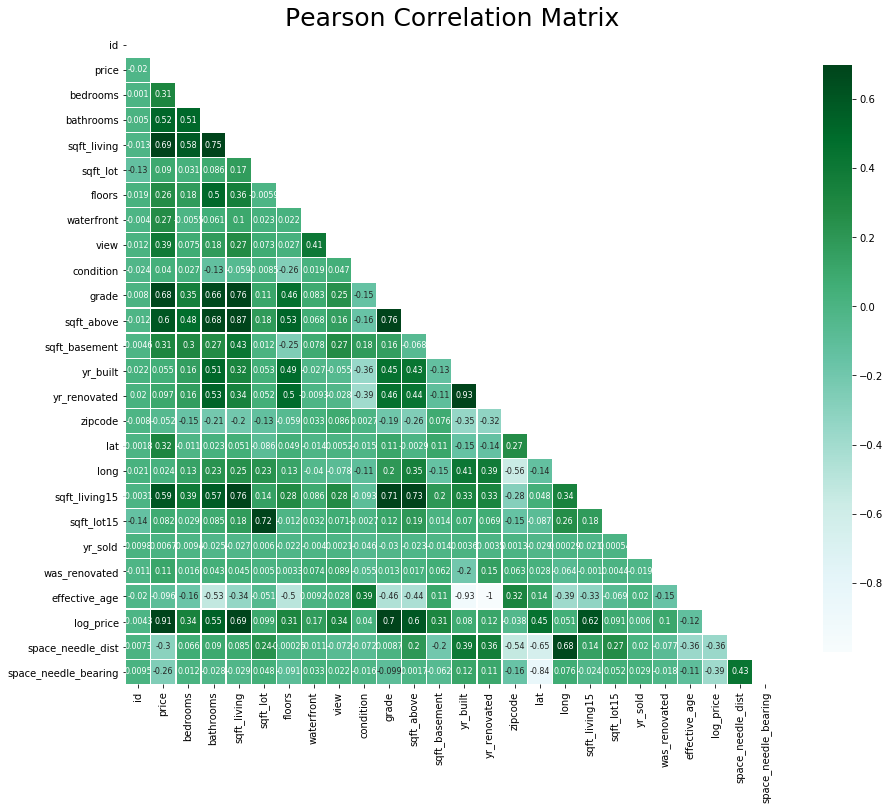

In [5]:
features = list(df.columns)

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});


In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=16)


In [7]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_lat_long_logprice = train_set[['lat', 'long']]

train_scaled = scaler.fit_transform(train_lat_long_logprice)
pd.DataFrame(train_scaled).describe()



,0,1
count,1.726900e+04,1.726900e+04
mean,2.987612e-14,5.531320e-15
std,1.000029e+00,1.000029e+00
min,-2.912024e+00,-2.166252e+00
25%,-6.526990e-01,-8.118653e-01
50%,8.865324e-02,-1.169447e-01
75%,8.501588e-01,6.347042e-01
max,1.562721e+00,6.371345e+00


Text(0, 0.5, 'Inertia')

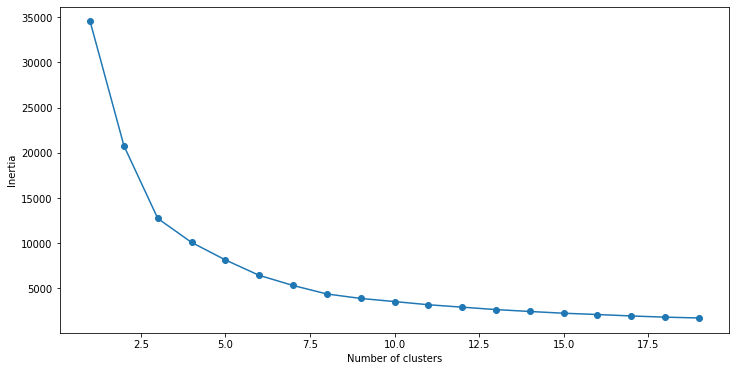

In [8]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(train_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [9]:
kmeans = KMeans(n_jobs = -1, n_clusters = 6, init='k-means++', random_state=16)
kmeans.fit(train_scaled)
train_pred = kmeans.predict(train_scaled)


train_frame = pd.DataFrame(train_scaled)
train_frame['cluster'] = train_pred
train_frame['cluster'].value_counts()

train_centers = kmeans.cluster_centers_
train_centers_frame = pd.DataFrame(scaler.inverse_transform(train_centers), columns=['klat', 'klong'])
train_centers_frame.sort_values(by='klat', inplace=True)
train_centers_frame.reset_index(drop=True, inplace=True)
train_centers_frame


,klat,klong
0,47.331219,-122.302298
1,47.392458,-122.116346
2,47.534679,-122.314847
3,47.558268,-121.925526
4,47.653871,-122.122604
5,47.695203,-122.326117


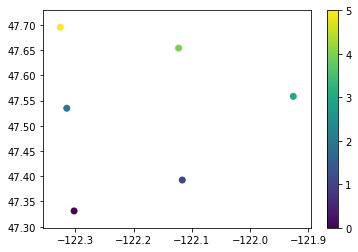

In [10]:
plt.scatter(train_centers_frame.klong, train_centers_frame.klat, c = train_centers_frame.index,
           label = train_centers_frame.index)
plt.colorbar()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


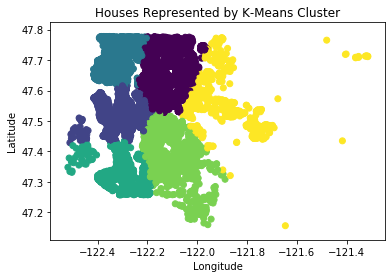

In [11]:
train_set['cluster'] = train_pred
plt.scatter(train_set.long, train_set.lat, c=train_set.cluster)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Houses Represented by K-Means Cluster')
plt.show()

In [12]:
def distance_from(flat, flong, lat, long):
    """return 'as the crow flies' distance in miles from the 
    space needle, given latitude and longitude coordinates of a location"""
    # Convert lat/longitudes to radians
    def to_radians(latlong):
        return latlong / 57.29577951
    # lat/long of input
    loc_lat = to_radians(lat)
    loc_long = to_radians(long)
    c_lat = to_radians(flat)
    c_long = to_radians(flong)
    # distance in miles
    d = 3963.0 * np.arccos((np.sin(c_lat) * np.sin(loc_lat))\
                           + np.cos(c_lat) * np.cos(loc_lat)\
                           * np.cos(loc_long - c_long))
    return d

    
# Create a Function for computing the bearing relative from space needle
# of a given lat/long point
def bearing_from(flat, flong, lat, long):
    """return bearing theta in radians for given location's
    bearing relative to the space needle. Takes latitude and longitude
    of the location."""
    delta_fi = np.log(np.tan(flat / 2 + np.pi/4) / np.tan(lat / 2 + np.pi/4))
    delta_lon = abs(flong - long)
    bearing = np.arctan2(delta_lon, delta_fi)
    return bearing

In [22]:
# drop_cols = train_set.columns[-9:]
# train_set.drop(columns=drop_cols, inplace=True)

In [23]:
# train_set.columns[-9:]

In [13]:
train_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,yr_sold,was_renovated,effective_age,log_price,space_needle_dist,space_needle_bearing,cluster
12702,5014000085,2014-06-23,425000.0,2,1.0,880,6413,1.0,0.0,0.0,...,-122.395,1360,6413,2014,False,64.0,12.959844,3.916347,2.433389,1
10450,6056100295,2014-05-30,330000.0,2,2.5,1240,1546,2.0,0.0,0.0,...,-122.298,1520,2468,2014,False,7.0,12.706848,4.617857,2.465859,1
10209,8947250060,2015-03-26,292500.0,4,2.5,1610,4568,2.0,NaN,0.0,...,-122.289,1834,4604,2015,False,9.0,12.586220,19.940631,2.946766,3
7095,9297300480,2014-12-12,765000.0,4,3.5,2760,4000,2.0,0.0,2.0,...,-122.374,1690,4000,2014,True,0.0,13.547631,3.763555,2.739803,1
19486,8151600900,2014-11-12,445000.0,5,3.0,2420,11250,2.0,0.0,0.0,...,-122.362,1510,9950,2014,False,1.0,13.005830,7.790081,3.039728,1


In [14]:
for i in train_centers_frame.index:
    dist_col_name = f'dist_c{i}'
    bear_col_name = f'bear_c{i}'
    train_set[dist_col_name] = distance_from(train_centers_frame.loc[i, 'klat'], train_centers_frame.loc[i, 'klong'], train_set.lat, train_set.long)
    train_set[bear_col_name] = bearing_from(train_centers_frame.loc[i, 'klat'], train_centers_frame.loc[i, 'klong'], train_set.lat, train_set.long)

# train_set['dist_c0'] = distance_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], train_set.lat, train_set.long)
# train_set['bear_c0'] = bearing_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], train_set.lat, train_set.long)
# train_set['dist_c1'] = distance_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], train_set.lat, train_set.long)
# train_set['bear_c1'] = bearing_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], train_set.lat, train_set.long)
# train_set['dist_c2'] = distance_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], train_set.lat, train_set.long)
# train_set['bear_c2'] = bearing_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], train_set.lat, train_set.long)
# # train_set['dist_c3'] = distance_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], train_set.lat, train_set.long)
# # train_set['bear_c3'] = bearing_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], train_set.lat, train_set.long)
# # train_set['dist_c4'] = distance_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], train_set.lat, train_set.long)
# # train_set['bear_c4'] = bearing_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], train_set.lat, train_set.long)
# train_set.drop(columns=['dist_c3', 'dist_c4', 'bear_c3', 'bear_c4'], inplace=True)
train_set


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,dist_c1,bear_c1,dist_c2,bear_c2,dist_c3,bear_c3,dist_c4,bear_c4,dist_c5,bear_c5
12702,5014000085,2014-06-23,425000.0,2,1.00,880,6413,1.0,0.0,0.0,...,18.044456,0.964656,4.585313,1.086561,21.934190,1.536099,13.878366,1.895431,9.041648,2.684857
10450,6056100295,2014-05-30,330000.0,2,2.50,1240,1546,2.0,0.0,0.0,...,14.557210,0.782999,2.136555,0.490732,17.388716,1.555592,10.298298,2.098831,9.210171,2.957270
10209,8947250060,2015-03-26,292500.0,4,2.50,1610,4568,2.0,NaN,0.0,...,9.009377,1.900380,13.857255,3.019162,22.963753,2.146521,23.379654,2.690938,24.967637,3.047282
7095,9297300480,2014-12-12,765000.0,4,3.50,2760,4000,2.0,0.0,2.0,...,17.136687,0.939449,3.628044,1.007084,20.943728,1.545098,13.119502,1.937104,9.030014,2.822535
19486,8151600900,2014-11-12,445000.0,5,3.00,2420,11250,2.0,0.0,0.0,...,14.003878,1.108936,2.864527,2.117868,20.675087,1.695210,15.042417,2.167301,13.042291,2.973192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17738,126059019,2015-03-16,799000.0,4,2.50,3170,94855,1.0,0.0,0.0,...,25.754716,0.010395,18.511626,0.649595,16.719156,0.658147,7.688548,0.079429,11.063699,1.194046
581,7511800070,2014-08-21,264000.0,3,1.50,1820,10608,1.0,0.0,0.0,...,9.688817,1.865286,13.706888,3.099192,23.490521,2.122927,23.559052,2.649805,24.821401,3.090169
2171,1796381070,2014-06-25,270000.0,3,2.50,1670,8364,1.0,0.0,0.0,...,2.219814,2.214200,15.744820,2.220145,15.043068,2.474233,19.786132,3.017339,25.237177,2.546420
15607,2019200480,2014-08-13,220000.0,3,2.25,1470,7518,1.0,0.0,0.0,...,11.956721,2.159778,18.147582,3.087400,26.417391,2.245506,27.651980,2.731033,29.262711,3.084385


In [35]:
col_combos = [f'+ dist_c{i}*bear_c{i} ' for i in train_centers_frame.index]
# formula = 'log_price ~ sqft_living ' + ''.join(col_combos)

model = smf.ols(formula=formula, data=train_set)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     4436.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:05:03   Log-Likelihood:                 680.06
No. Observations:               17269   AIC:                            -1326.
Df Residuals:                   17252   BIC:                            -1194.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.5977      0.068    199.313      0.000      13.464      13.731
sqft_living         0.0004    2.1e-06    176.760      0.000       0.000       0.000
dist_c0            -0.0450      0.003    -16.637      0.000      -0.050      -0.040
bear_c0             0.0318      0.010      3.151      0.002       0.012       0.052
dist_c1            -0.0138      0.004     -3.839      0.000      -0.021      -0.007
dist_c1:bear_c1     0.0235      0.001     16.696      0.000       0.021       0.026
dist_c2            -0.0411      0.004    -10.548      0.000      -0.049      -0.033
bear_c2            -0.1377      0.008    -16.659      0.000      -0.154      -0.121
dist_c2:bear_c2     0.0486      0.002     22.804      0.000       0.044       0.053
bear_c3             0.1056      0.014      7.764      0.000       0.079       0.132
dist_c3:bear_c3     0.0168      0.001     16.370      0.000       0.015       0.019
dist_c4            -0.0218      0.004     -5.862      0.000      -0.029      -0.015
bear_c4             0.0202      0.008      2.530      0.011       0.005       0.036
dist_c4:bear_c4    -0.0150      0.002     -6.813      0.000      -0.019      -0.011
dist_c5             0.1223      0.004     28.295      0.000       0.114       0.131
bear_c5             0.1996      0.008     26.532      0.000       0.185       0.214
dist_c5:bear_c5    -0.0833      0.002    -39.845      0.000      -0.087      -0.079
==============================================================================
Omnibus:                     1084.747   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4139.692
Skew:                           0.211   Prob(JB):                         0.00
Kurtosis:                       5.361   Cond. No.                     8.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
cols = list(fitted_model.pvalues[fitted_model.pvalues < .05].index[1:])
cols
formula = 'log_price ~ '
formula_join = '+ '.join(cols)
formula += formula_join

In [36]:
# train_set.columns[-10:]
cols = list(train_set.columns[-12:])
cols.append('sqft_living')


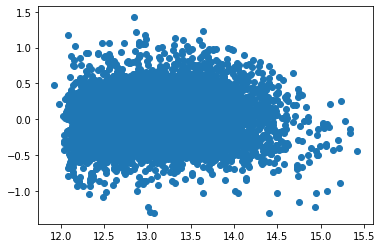

In [37]:
x_preds = train_set[cols]
y_actual = train_set['log_price']
model_predictions = fitted_model.predict(x_preds)
residuals = y_actual - model_predictions
plt.scatter(model_predictions, residuals)


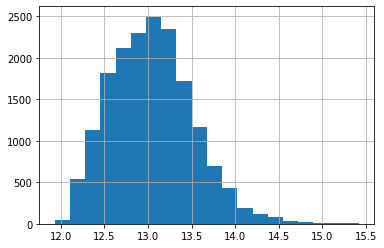

In [38]:
model_predictions.hist(bins=20)

In [30]:
outliers = list(model_predictions[model_predictions >15.5].index)
outliers

[7028]

In [31]:

living_8000 = train_set.sqft_living >= 8000


In [32]:
len(train_set) - len(train_set.loc[~ living_8000])

0

In [33]:
train_set.loc[train_set.index.isin(outliers), list(train_set.columns[2:-20])]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
7028,3800000.0,5,5.5,7050,42840,1.0,0.0,2.0,4,13,4320,2730,1978,1978.0,98004,47.6229,-122.22


In [34]:
"""Cell returns error:
Error evaluating factor: NameError: name 'dist_c1' is not defined

VERY briefly checked notebook above, but did not see where error arises"""

test_set['dist_c0'] = distance_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], test_set.lat, test_set.long)
test_set['bear_c0'] = bearing_from(train_centers_frame['klat'][0], train_centers_frame['klong'][0], test_set.lat, test_set.long)
test_set['dist_c1'] = distance_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], test_set.lat, test_set.long)
test_set['bear_c1'] = bearing_from(train_centers_frame['klat'][1], train_centers_frame['klong'][1], test_set.lat, test_set.long)
test_set['dist_c2'] = distance_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], test_set.lat, test_set.long)
test_set['bear_c2'] = bearing_from(train_centers_frame['klat'][2], train_centers_frame['klong'][2], test_set.lat, test_set.long)
test_set['dist_c3'] = distance_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], test_set.lat, test_set.long)
test_set['bear_c3'] = bearing_from(train_centers_frame['klat'][3], train_centers_frame['klong'][3], test_set.lat, test_set.long)
test_set['dist_c4'] = distance_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], test_set.lat, test_set.long)
test_set['bear_c4'] = bearing_from(train_centers_frame['klat'][4], train_centers_frame['klong'][4], test_set.lat, test_set.long)



test_x_preds = test_set[['sqft_living', 'dist_c0', 'bear_c0', 'bear_c1', 'dist_c2', 'bear_c2', 'dist_c3', 'bear_c3', 'dist_c4', 'bear_c4']]

test_preds = fitted_model.predict(test_x_preds)

log_price_mean = test_set.log_price.mean()
TSS = ((test_set.log_price - (log_price_mean))**2).sum()
RSS = ((test_set.log_price - test_preds)**2).sum()

R_sq = 1 - (RSS / TSS)

R_sq

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'dist_c1' is not defined
    log_price ~ sqft_living + dist_c0*bear_c0 + dist_c1*bear_c1 + bear_c2 + dist_c2:bear_c2+ dist_c3*bear_c3 + dist_c4*bear_c4
                                                ^^^^^^^

In [ ]:
# df['cluster'] = pred

# df['log10_price'] = np.log10(df.price)
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('seaborn-white')
r = train_set.space_needle_dist
theta = train_set.space_needle_bearing
area = train_set.log_price
colors = train_set.cluster


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, alpha=0.4 )
ax.set_theta_zero_location('W', offset=90)
ax.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
ax.set_xticklabels(['South','East', 'North', 'West'])
#ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
ax.set_rmax(45)
#ax.set_tickparams(axis='y', colors='red')
#ax.r_label_position('right')
ax.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
ax.set_ylabel('Distance in Miles', labelpad=100)
ax.yaxis.set_label_position('right')
#ax.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')




ax1 = fig.add_subplot(122, projection='polar')
c2 = ax1.scatter(theta, r, c=area, s=area, alpha=0.4)
ax1.set_theta_zero_location('W', offset=90)
ax1.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
ax1.set_xticklabels(['South','East', 'North', 'West'])
#ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
ax1.set_rmax(40)
#ax.set_tickparams(axis='y', colors='red')
#ax.r_label_position('right')
ax1.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
ax1.set_ylabel('Distance in Miles', labelpad=100)
ax1.yaxis.set_label_position('right')
#ax1.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')

# ax3 = fig.add_subplot(133, projection='polar')
# c3 = ax3.scatter(theta, r, c=colors2, s=area, alpha=0.4)
# ax3.set_theta_zero_location('W', offset=90)
# ax3.set_xticks(np.array([0, 90, 180, 270])*np.pi/180)
# ax3.set_xticklabels(['South','East', 'North', 'West'])
# #ax.set_rticks([0,5,10,15,20,25,30,35,40,45,50])
# ax3.set_rmax(40)
# #ax.set_tickparams(axis='y', colors='red')
# #ax.r_label_position('right')
# ax3.set_rgrids([5,10,15,20,25,30,35], angle=70, color='green')
# ax3.set_ylabel('Distance in Miles', labelpad=100)
# ax3.yaxis.set_label_position('right')
# #ax.set_title('Distance and Direction from Space Needle, colored by Log 10 Sale Price')



In [ ]:
"""Commented out as this graph is already being created at the top"""
# plt.scatter(train_set.long, train_set.lat, c=train_set.cluster)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


lat_long_logprice = df[['lat', 'long', 'log_price']]
data_scaled = scaler.fit_transform(lat_long_logprice)


db = DBSCAN(eps=0.3, min_samples=10).fit(data_scaled)

labels = db.labels_

df['cluster_db'] = labels

df.head()




In [ ]:
df.cluster_db.value_counts()

In [ ]:
df.columns